## 1. Defining Dataset

In [1]:
import pandas as pd

csv_url = 'https://raw.githubusercontent.com/kanish-h-h/monthly_armed_robbery/main/data/Robberies.csv'
series = pd.read_csv(csv_url, index_col=0)
series.head()

,Robberies
Months,
1966-01,41
1966-02,39
1966-03,50
1966-04,40
1966-05,43


## 2. Creating validation Dataset

In [2]:
from pandas import read_csv

series = read_csv(csv_url, header=0, index_col=0, parse_dates=True)
series = series.squeeze()

split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print(f'Dataset {len(dataset)}, Validation {len(validation)}')
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 106, Validation 12


## 3. Model Evaluation

Model Evaluation involves two steps:
1. Performance Measure --> RMSE
2. Test Strategy

In [3]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.5)
train, test =  X[0:train_size], X[train_size:]

# walk through validation
history = [x for x in train]
prediction = list()
for i in range(len(test)):
  # predict
  yhat = history[-1]
  prediction.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print(f'predicted={yhat}, expected={obs}')

# report performance
rmse = sqrt(mean_squared_error(test, prediction))
print(f'RMSE: {rmse}')

predicted=174.0, expected=178.0
predicted=178.0, expected=136.0
predicted=136.0, expected=161.0
predicted=161.0, expected=171.0
predicted=171.0, expected=149.0
predicted=149.0, expected=184.0
predicted=184.0, expected=155.0
predicted=155.0, expected=276.0
predicted=276.0, expected=224.0
predicted=224.0, expected=213.0
predicted=213.0, expected=279.0
predicted=279.0, expected=268.0
predicted=268.0, expected=287.0
predicted=287.0, expected=238.0
predicted=238.0, expected=213.0
predicted=213.0, expected=257.0
predicted=257.0, expected=293.0
predicted=293.0, expected=212.0
predicted=212.0, expected=246.0
predicted=246.0, expected=353.0
predicted=353.0, expected=339.0
predicted=339.0, expected=308.0
predicted=308.0, expected=247.0
predicted=247.0, expected=257.0
predicted=257.0, expected=322.0
predicted=322.0, expected=298.0
predicted=298.0, expected=273.0
predicted=273.0, expected=312.0
predicted=312.0, expected=249.0
predicted=249.0, expected=286.0
predicted=286.0, expected=279.0
predicte

## 4. Data Analysis

We will look data from four differnect perspective
1. Summary Statistics
2. Line Plots
3. Density Plot
4. Box and Whisker Plot

### 4.1 Summary Statistics

In [4]:
import pandas as pd

series = pd.read_csv('dataset.csv', index_col=0).squeeze()
series.describe()

count    105.000000
mean     174.361905
std      112.015806
min       29.000000
25%       77.000000
50%      149.000000
75%      273.000000
max      487.000000
Name: 41, dtype: float64

### 4.2 Line Plot

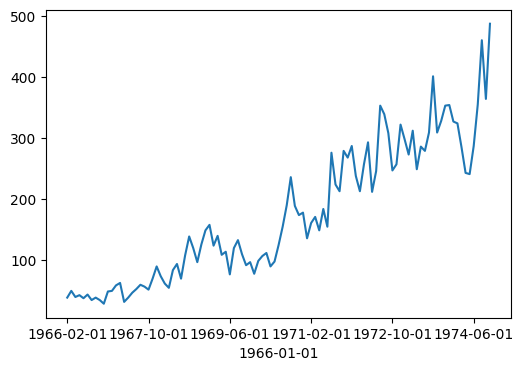

In [5]:
import matplotlib.pyplot as pyplot
series.plot(figsize=(6,4))
pyplot.show()

### 4.3 Density Plot

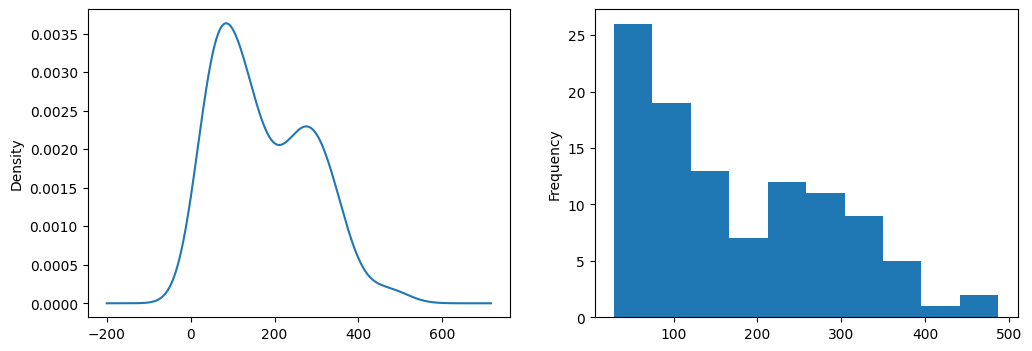

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12,4))

series.plot(kind='kde', ax=ax[0])
series.plot(kind='hist', ax=ax[1])
plt.show()

### 4.4 Box and Whisker plot

0
1966-01-01     41
1966-02-01     39
1966-03-01     50
1966-04-01     40
1966-05-01     43
             ... 
1974-06-01    287
1974-07-01    355
1974-08-01    460
1974-09-01    364
1974-10-01    487
Name: 1, Length: 106, dtype: int64


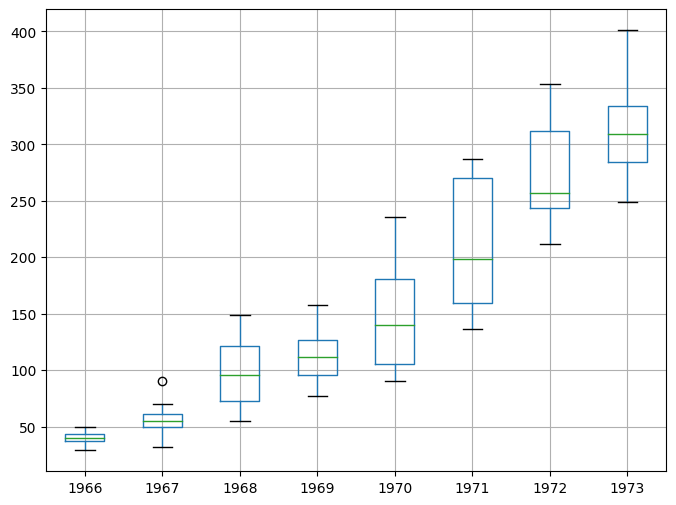

In [7]:
from pandas import  read_csv, DataFrame, Grouper, concat
import matplotlib.pyplot as plt
import numpy as np

series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()
print(series)

groups = series['1966':'1973'].groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
  years[name.year] = group.values

years.boxplot(figsize=(8,6))
plt.show()

## 5. ARIMA Models

For this we devlop **Autoregressive Integrate Moving Avergae** or **ARIMA**.


Here we have to approach these four steps:
1. Manually configred ARIMA Model
2. Using a search grid of ARIMA to find a optimized model
3. Analysis of forecast residual errors to evaluate any bias in the model.
4. Explore improvements to the model using poer transforms

### 5.1 Manually Configured ARIMA

Analysis of the time series data assumes that we are working with a stationary time series, time series is almost certainly non-statonary.

In [8]:
# using stationary test for the stationarity of the time series
from pandas import read_csv, Series
from statsmodels.tsa.stattools import adfuller

# create a differenced time series
def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i - 1]
    diff.append(value)
  return Series(diff)

series = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True).squeeze()
X = series.values

# difference data
stationary = difference(X)
result = adfuller(stationary)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
  print(f'\t{key} : {value}')

# save
stationary.to_csv('stationary.csv', header=False)

ADF Statistic: -3.954222888983672
p-value: 0.001670123204826468
Critical Values:
	1% : -3.503514579651927
	5% : -2.893507960466837
	10% : -2.583823615311909


With this we can conclude that at least one level of differencing is required.
ARIMA model should have atleast value of 1. Next, reviewing ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) plots.

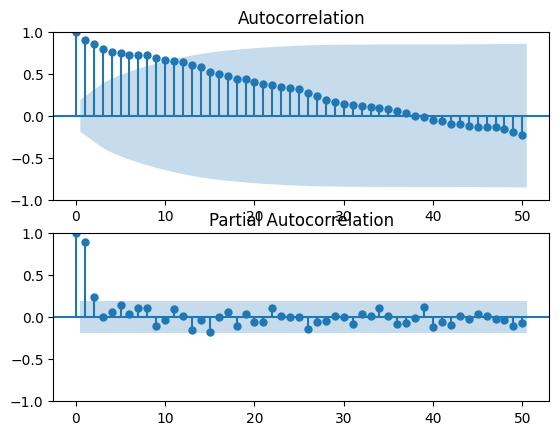

In [9]:
# ACF and PACF plots for time series
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot

series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, lags=50, ax=pyplot.gca())

pyplot.subplot(212)
plot_pacf(series, lags=50, ax=pyplot.gca())
pyplot.show()

Some observations from the plots.
- The ACF shows a significant lag for 10-11 months.
- The PACF shows a significant lag for perhaps 2 months.
- Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of AR and MA.

A good starting point for the p and q values are 11 and 2.

Nonseasonal ARIMA(p, d, q) requires three parameters.
Therefore ARIMA(11, 1, 2) on a raw data. Moreover over study it shows that the model does not appear to be stable, with non-zero AR and MA orders defined at the same-time. Therefore simplifying this we have **ARIMA(0,1,2)**

In [10]:
# manually configured ARIMA Model
from pandas import read_csv
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

# load dataset
series = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True).squeeze()

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-through validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(0,1,2))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)

  #observation
  obs = test[i]
  history.append(obs)
  print(f'Predicted={yhat}, Excepted={obs}')

# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse}')

Predicted=99.93296475368287, Excepted=125.0
Predicted=116.46076714064168, Excepted=155.0
Predicted=139.98653365675548, Excepted=190.0
Predicted=176.95770472540107, Excepted=236.0
Predicted=232.88940110885267, Excepted=189.0
Predicted=184.62395273662972, Excepted=174.0
Predicted=180.71827901320137, Excepted=178.0
Predicted=179.86698928242043, Excepted=136.0
Predicted=141.05968091734238, Excepted=161.0
Predicted=166.22332221836666, Excepted=171.0
Predicted=166.9931977910428, Excepted=149.0
Predicted=150.64393105718065, Excepted=184.0
Predicted=182.35881116052215, Excepted=155.0
Predicted=154.1704781279445, Excepted=276.0
Predicted=245.2301174216299, Excepted=224.0
Predicted=225.9235613594598, Excepted=213.0
Predicted=216.8688969138562, Excepted=279.0
Predicted=258.6974559165748, Excepted=268.0
Predicted=263.38291519960717, Excepted=287.0
Predicted=279.94716764779747, Excepted=238.0
Predicted=251.48882069689705, Excepted=213.0
Predicted=226.5703350564322, Excepted=257.0
Predicted=249.6904

### 5.2 Grid Search ARIMA Hyperparameters


Searching different values of **p**, **d** and **q**

* p: 0 to 12
* d: 0 to 3
* q: 0 to 12

this is (13 x 4 x 13) or 676, runs of test to harness to get appropiate values of p, d, q for our ARIMA model.


In [11]:
# grid search ARIMA parameters for time series
import warnings
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate an ARIMA model for a given order (p,d, q) and return RMSE
def evaluate_arima_model(X, arima_order):
  # prepare training datasets
  X = X.astype('float32')
  train_size = int(len(X) * 0.50)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]

  # make predicitons
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])

  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse


# evaluate combinations of p, d, and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float('inf'), None

  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print(f'ARIMA={order} RMSE-={rmse}')
        except:
          continue
  print(f'Best ARIMA={best_cfg} RMSE={best_score}')


# load dataset
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()

# evaluate parameters
p_values = range(0, 13)
d_values = range(0, 4)
q_values = range(0, 13)
warnings.filterwarnings('ignore')
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA=None RMSE=inf


### 5.3 Review Residual Errors

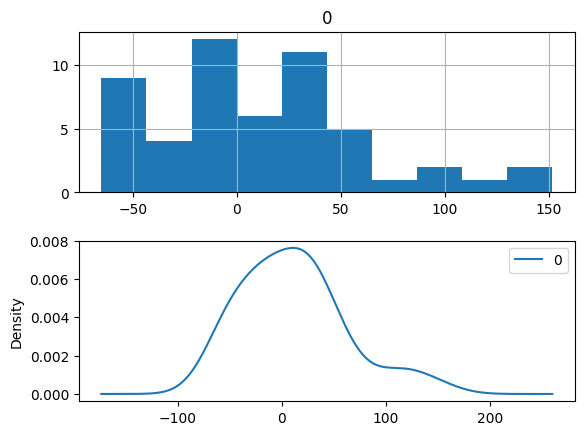

In [12]:
# plot residual errors for ARIMA model
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(0,1,2))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)

  # observation
  obs = test[i]
  history.append(obs)

# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)

pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())

pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

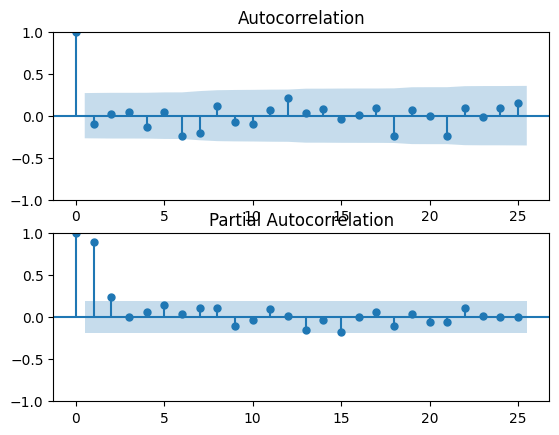

In [13]:
# ACF and PACF plots of forecast residual errors
from pandas import read_csv, DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(0,1,2))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)

  # observation
  obs = test[i]
  history.append(obs)

# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)

pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, lags=25, ax=pyplot.gca())

pyplot.subplot(212)
plot_pacf(series, lags=25, ax=pyplot.gca())
pyplot.show()

### 5.4 Box-Cox Transformed Dataset

The following graphs performs a log transform of the data and generates some plots to review the effect on the time series.

Lambda: 0.26006033924618177


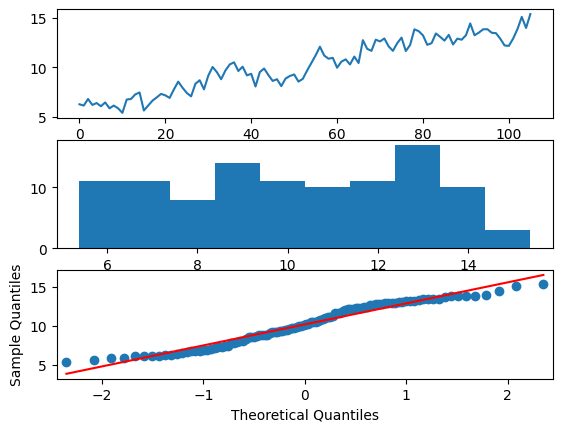

In [16]:
# plots of box-cox transformed dataset
from pandas import read_csv
from scipy.stats import boxcox
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot

series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()
X = series.values

transformed, lam = boxcox(X)
print(f'Lambda: {lam}')

pyplot.figure()

# line plot
pyplot.subplot(311)
pyplot.plot(transformed)

# histogram
pyplot.subplot(312)
pyplot.hist(transformed)

# qqplot
pyplot.subplot(313)
qqplot(transformed, line='r', ax=pyplot.gca())
pyplot.show()

A line chart of the transformed time series, a histogram showing the distribution of transformed values, and a Q-Q plot showing how the
distribution of values compared to an idealized Gaussian distribution.
Some observations from these plots are follows:

* The large fluctuations have been removed from the line plot of the time series.
* The histogram shows a flatter or more uniform (well behaved) distribution of values.
* The Q-Q plot is reasonable, but still not a perfect fit for a Gaussian distribution.

Undoubtedly, the Box-Cox transform has done something to the time series and may be useful. Before proceeding to test the `ARIMA` model with the transformed data, \
we must have a way to reverse the transform in order to convert predictions made with a model trained on the transformed data back into the original scale.

The `boxcox()` function used in the example finds an ideal `lambda` value by optimizing a cost function. The lambda is used in the following function to transform the data.

$$ transform = log(x), \ IF \ lambda = 0 $$

$$ transform = \frac{x^{lambda} - 1}{lambda}, \ IF \ lambda \neq 0 $$
\
This transform function can be revered directly, as follows:

$$ x = erp(transform), \ IF \ lambda = 0 $$

$$ x = exp( \frac{log(lambda \ * \ transform + 1)}{lambda}), \ IF \ lambda \neq 0 $$

In [18]:
# invert Box-Cox transform
from math import log, exp

def boxcox_inverse(value, lam):
  if lam == 0:
    return exp(value)
  return exp(log(lam * value + 1) / lam)

By convention, `lambda` value are evaluated between -5 and 5. \
A lambda value of 1 is the same as `no-transform` and therefore the inverse transform has no effect.

In [21]:
# evaluate ARIMA models with box-cox transformed time series
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMAResults
from math import sqrt, log, exp
from scipy.stats import boxcox

# invert Box-Cox transform
from math import log, exp

def boxcox_inverse(value, lam):
  if lam == 0:
    return exp(value)
  return exp(log(lam * value + 1) / lam)

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
  # transform
  transform, lam = boxcox(history)
  if lam < -5:
    transform, lam = history, 1

  # predict
  model = ARIMA(transform, order=(0,1,2))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]

  # invert transformed prediction
  yhat = boxcox_inverse(yhat, lam)
  predictions.append(yhat)

  # observation
  obs = test[i]
  history.append(obs)
  print(f'Predicted={yhat}, Expected={obs}')

# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse}')

Predicted=99.6504425929835, Expected=125.0
Predicted=115.20815784935795, Expected=155.0
Predicted=136.14815279134075, Expected=190.0
Predicted=165.52193050267854, Expected=236.0
Predicted=206.4525409708625, Expected=189.0
Predicted=180.9343020261563, Expected=174.0
Predicted=178.19572048223299, Expected=178.0
Predicted=179.31579375277497, Expected=136.0
Predicted=145.46033801438062, Expected=161.0
Predicted=165.56755313688086, Expected=171.0
Predicted=166.48357454950389, Expected=149.0
Predicted=152.06488910173528, Expected=184.0
Predicted=179.56062836174755, Expected=155.0
Predicted=155.21065239750217, Expected=276.0
Predicted=238.9772828743197, Expected=224.0
Predicted=210.75287544584938, Expected=213.0
Predicted=214.07461160036826, Expected=279.0
Predicted=257.44744438178736, Expected=268.0
Predicted=255.41313369498727, Expected=287.0
Predicted=275.9414252647094, Expected=238.0
Predicted=245.0895715450814, Expected=213.0
Predicted=226.69922087628183, Expected=257.0
Predicted=252.343

# 6. Model Validation


* **Finalize Model:** Train and save the final model
* **Make Predictions:** Load the finalized model and make a prediction.
* **Validate Model:** Load and validate the final model.

## 6.1 Finalize Model

In [22]:
# finalize model and save to file with workaround
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import numpy

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()

# prepare data
X = series.values
X = X.astype('float32')

# transform data
transform, lam = boxcox(X)

# fit model
model= ARIMA(transform, order=(0,1,2))
model_fit = model.fit()

# save model
model_fit.save('model.pkl')
numpy.save('model_lambda.npy', [lam])

## 6.2 Make Prediction

In [31]:
# load the finalized model and make a prediction
from statsmodels.tsa.arima.model import ARIMAResults
from math import exp, log
import numpy

# invert box_cox transform
def boxcox_inverse(value, lam):
  if lam == 0:
    return exp(value)
  return exp(log(lam * value + 1) / lam)

model_fit = ARIMAResults.load('model.pkl')
lam = numpy.load('model_lambda.npy')

yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
print(f'Predicted: {yhat}')

Predicted: 452.3653951024324


## 6.3 Validate Model


Predicted=452.3653951024324, Expected=452.0
Predicted=429.9002611961608, Expected=391.0
Predicted=401.3933145124251, Expected=500.0
Predicted=476.4607055719382, Expected=451.0
Predicted=442.45433666993034, Expected=375.0
Predicted=397.52650167215324, Expected=372.0
Predicted=390.64705870480793, Expected=302.0
Predicted=329.393360646611, Expected=316.0
Predicted=334.17093579953564, Expected=398.0
Predicted=382.8187158384033, Expected=394.0
Predicted=378.50823919026186, Expected=431.0
Predicted=413.5254835108158, Expected=431.0
RMSE: 51.94883457711568


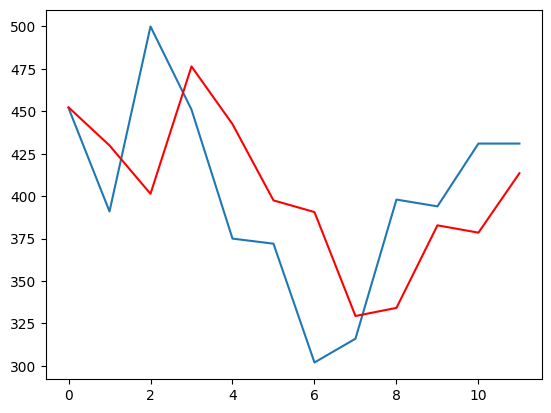

In [33]:
# evaluate the finalized model on the validate dataset
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt, log, exp

# invert box_cox transform
def boxcox_inverse(value, lam):
  if lam == 0:
    return exp(value)
  return exp(log(lam * value + 1) / lam)

# load and prepare datasets
dataset = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()
X = dataset.values.astype('float32')
history = [x for x in X]

validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True).squeeze()
y = validation.values.astype('float32')

# load model
model_fit = ARIMAResults.load('model.pkl')
lam = numpy.load('model_lambda.npy')

# make first prediciton
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
predictions.append(yhat)
history.append(y[0])
print(f'Predicted={yhat}, Expected={y[0]}')

# rolling forecasts
for i in range(1, len(y)):
  # transform
  transform, lam = boxcox(history)
  if lam < -5:
    transform, lam = history, 1

  # predict
  model = ARIMA(transform, order=(0,1,2))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]

  # invest transformed prediciton
  yhat = boxcox_inverse(yhat, lam)
  predictions.append(yhat)

  # observation
  obs = y[i]
  history.append(obs)
  print(f'Predicted={yhat}, Expected={obs}')

# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print(f'RMSE: {rmse}')

pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()